In [3]:
import pandas as pd
import numpy as np

import ruptures as rpt
from ruptures.metrics import precision_recall
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

import lightgbm as lgb
import seaborn as sns

In [4]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 9]

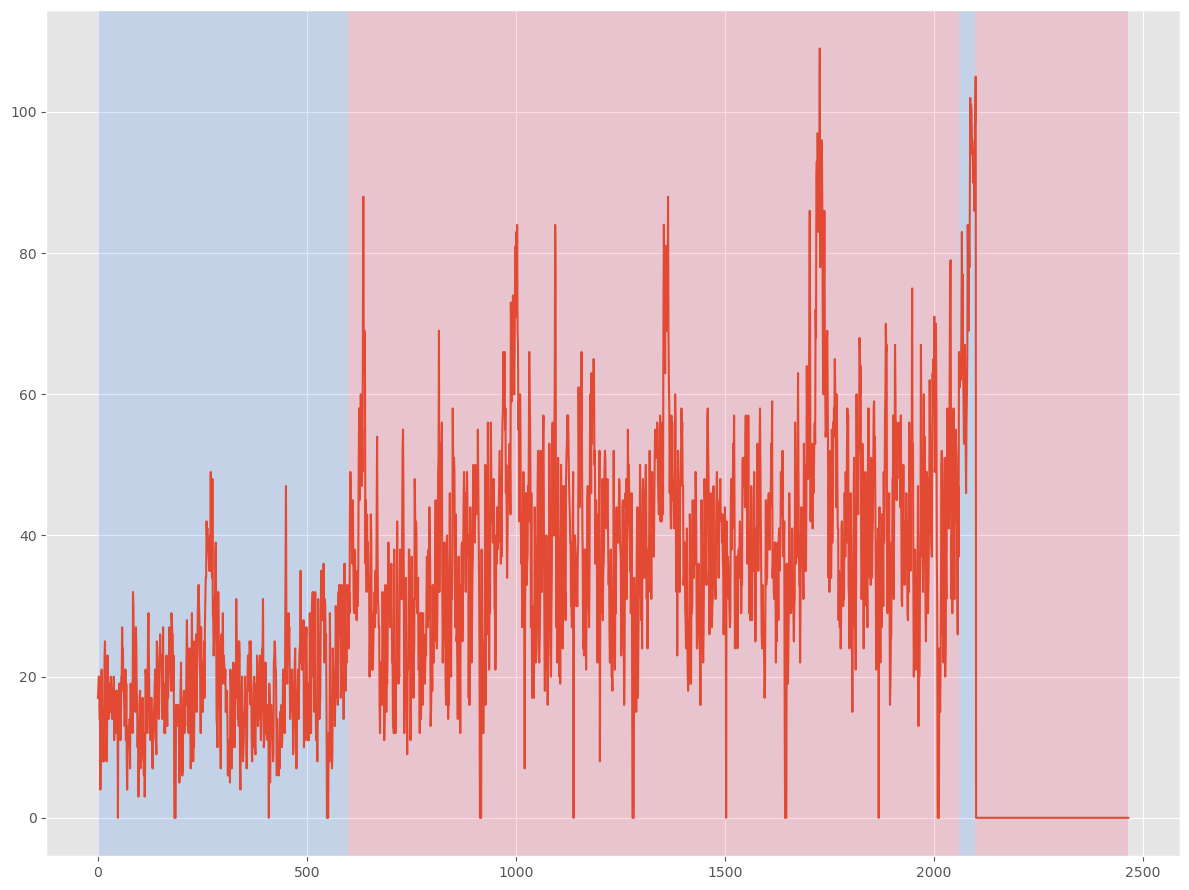

[600, 2060, 2100, 2466]


y  client  close  price_am  price_pm  price  year  month  \
datetime                                                                
2012-02-21  24       0      0       0.0       0.0    0.0  2012      2   
2012-02-22  32       0      0       0.0       0.0    0.0  2012      2   
2012-02-23  29       0      0       1.0       0.0    0.5  2012      2   
2012-02-24  43       0      0       1.0       1.0    1.0  2012      2   
2012-02-25  49       0      0       3.0       2.0    2.5  2012      2   

            weekday  y_lag_365  price_am_lag_1  price_am_lag_7  \
datetime                                                         
2012-02-21        1       26.0             1.0             0.0   
2012-02-22        2       15.0             0.0             0.0   
2012-02-23        3       21.0             0.0             0.0   
2012-02-24        4       23.0             1.0             0.0   
2012-02-25        5       29.0             1.0             2.0   

            price_am_lag_365  price_pm_lag_1  price_pm_lag_7  \
datetime                                                       
2012-02-21               0.0             0.0             0.0   
2012-02-22               1.0             0.0             0.0   
2012-02-23               1.0             0.0             0.0   
2012-02-24               1.0             0.0             0.0   
2012-02-25               2.0             1.0             1.0   

            price_pm_lag_365  price_am_moving_avg_30  price_pm_moving_avg_30  
datetime                                                                      
2012-02-21               0.0                0.600000                0.333333  
2012-02-22               0.0                0.600000                0.333333  
2012-02-23               0.0                0.633333                0.333333  
2012-02-24               1.0                0.666667                0.366667  
2012-02-25               1.0                0.766667                0.433333

client  close  price_am  price_pm  price  year  month  weekday  \
datetime                                                                     
2016-04-01       1      0       3.0       2.0    2.5  2016      4        4   
2016-04-02       0      0       5.0       5.0    5.0  2016      4        5   
2016-04-03       1      0       2.0       2.0    2.0  2016      4        6   
2016-04-04       1      0       1.0       1.0    1.0  2016      4        0   
2016-04-05       0      0       1.0       1.0    1.0  2016      4        1   

            y_lag_365  price_am_lag_1  price_am_lag_7  price_am_lag_365  \
datetime                                                                  
2016-04-01       60.0             5.0             4.0               2.0   
2016-04-02       75.0             3.0             5.0               2.0   
2016-04-03       86.0             5.0             5.0               4.0   
2016-04-04       69.0             2.0             4.0               2.0   
2016-04-05       61.0             1.0             4.0               1.0   

            price_pm_lag_1  price_pm_lag_7  price_pm_lag_365  \
datetime                                                       
2016-04-01             4.0             5.0               2.0   
2016-04-02             2.0             5.0               1.0   
2016-04-03             5.0             4.0               3.0   
2016-04-04             2.0             4.0               2.0   
2016-04-05             1.0             4.0               1.0   

            price_am_moving_avg_30  price_pm_moving_avg_30  
datetime                                                    
2016-04-01                2.400000                2.266667  
2016-04-02                2.566667                2.433333  
2016-04-03                2.600000                2.500000  
2016-04-04                2.566667                2.500000  
2016-04-05                2.566667                2.500000

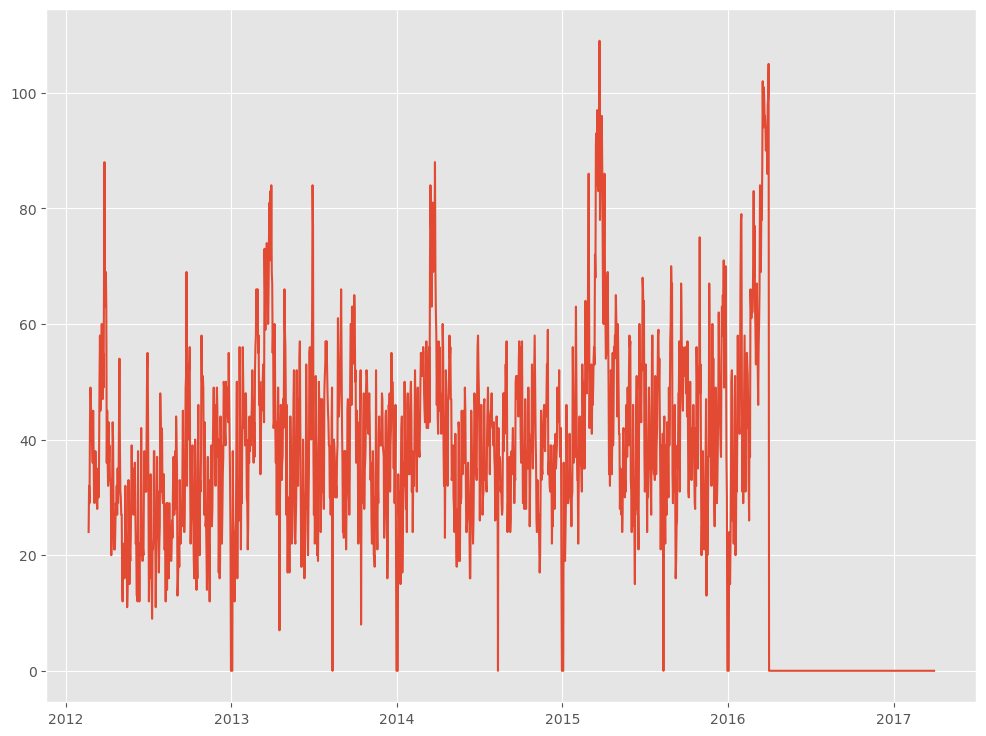

In [5]:
df = pd.read_csv('/Users/estyle-150/github/my_signage/data/processed/processed20240826.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

df.drop(['price_am_moving_avg_7', 'price_pm_moving_avg_7', 'day'], axis=1, inplace=True)

################
### 変化点検知 ###
################

# コスト関数の設定
model = "l2"
# アルゴの設定と学習
algo = rpt.Dynp(model=model).fit(df[['y']])
# 変化点の検出
my_bkps = algo.predict(n_bkps=3)
# 結果のプロット
rpt.show.display(df[['y']], my_bkps, figsize=(12, 9))
plt.show()
# 検出された変化点
print(my_bkps)

df = df[my_bkps[0]:]

# 訓練データをとる
train_data = df[df['is_train'] == 1].copy()

# テストデータをとる
test_data = df[df['is_train'] == 0].copy()

# 訓練データから不要な列（'is_train'）を削除
train_data.drop(['is_train'], axis=1, inplace=True)

# テストデータから不要な列を削除
test_data.drop(['y','is_train'], axis=1, inplace=True)

display(train_data.head(), test_data.head())


plt.plot(df['y'])

In [6]:
from sklearn.model_selection import KFold
import optuna.integration.lightgbm as lgb_op
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error

N = 365
X_train = train_data.drop(['y'], axis=1)[:-N]
y_train = train_data['y'][:-N]

X_test = train_data.drop(['y'], axis=1)[-N:]
y_test = train_data['y'][-N:]

# LightGBM用のデータセット
lgb_train = lgb.Dataset(X_train, y_train)
lgb.test = lgb.Dataset(X_test, y_test)

# 評価基準 
params = {"objective" : "regression", 
              "metric" : "mse", 
              "num_leaves" : 5,
              "early_stopping_rounds" : 50,
              "verbosity": -1}

# 回帰モデル作成
model = lgb.train(params, lgb_train, valid_sets=lgb.test)

# 予測
test_pred = model.predict(X_test)
pred_df = pd.concat([y_test.reset_index(drop=True), pd.Series(test_pred)], axis = 1)
pred_df.columns = ['true', 'pred']
pred_df

rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print('RMSE:',round(rmse,3))

RMSE: 9.592


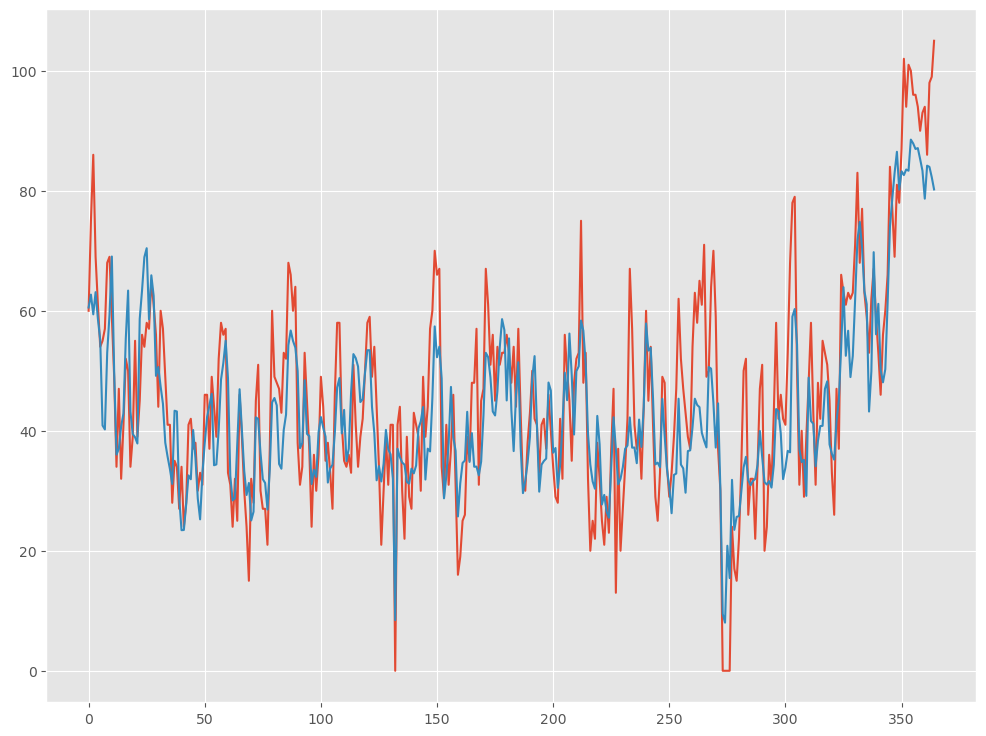

In [7]:
# 可視化
plt.plot(pred_df)

In [8]:
pred_submit = model.predict(test_data)
submit = pd.DataFrame({'date' : test_data.index, 'pred' : pred_submit})
submit.reset_index(drop=True)
submit.columns = submit.iloc[0]
#submit.to_csv('signate_ligthGBM_4.csv', index=False)

In [9]:
submit

0   2016-04-01 00:00:00  70.961541
0            2016-04-01  70.961541
1            2016-04-02  68.787517
2            2016-04-03  70.064284
3            2016-04-04  70.145450
4            2016-04-05  64.256969
..                  ...        ...
360          2017-03-27  81.897195
361          2017-03-28  82.444849
362          2017-03-29  83.447231
363          2017-03-30  85.175035
364          2017-03-31  81.801212

[365 rows x 2 columns]

In [10]:
# oputunaによるハイパーパラメータのチューニング
import optuna

In [11]:
# 固定値のハイパーパラメータ
params_base = {
    'objective' : 'regression',    # 損失関数
    'random_seed' : 123,    
    'learnig_rate' : 0.05,  # １回のブースティングで加算する重みの比率
    'min_data_in_bin' : 3,  # ヒストグラムの１つのbinに含まれる最小のレコード数
    'bagging_freq' : 0,
    'verbose' : -1,
}


# ハイパーパラメータの探索範囲
def objective(trial):
    params_turning = {
        'num_leaves' : trial.suggest_int('num_leaves', 50, 200),
        'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 2, 30),
        'max_bins' : trial.suggest_int('max_bin', 200, 400),
        'bagging_fraction' : trial.suggest_float('bagging_fraction', 0.8, 0.95),
        'feature_fraction' : trial.suggest_float('eature_fraction', 0.35, 0.65),
        'min_gain_to_split' : trial.suggest_float('min_gain_to_split', 0.01, 1, log=True),
        'lambda_11' : trial.suggest_float('lambda_11', 0.01, 1, log=True),
        'lambda_12' : trial.suggest_float('lambda_12', 0.01, 1, log=True),
    }
    
    # 探索用ハイパーパラメータの設定
    params_turning.update(params_base)
    lgb_train = lgb.Dataset(x_tr, y_tr)
    lgb_eval = lgb.Dataset(x_va, y_va)

    #探索用ハイパーパラメータで学習
    model = lgb.train(params_turning,
                      lgb_train,
                      num_boost_round=6000,
                      valid_sets=[lgb_train, lgb_eval],
                      valid_names=['train', 'valid'],
                      callbacks=[lgb.early_stopping(50),
                                 lgb.log_evaluation(500)])
    y_va_pred = model.predict(x_va,
                              num_iteration=model.best_iteration)
    score = mean_absolute_error(y_va, y_va_pred)
    print('')
    return score

In [12]:
x_tr = X_train
x_va = X_test
y_tr = y_train
y_va = y_test

In [13]:
# ハイパーパラメータの最適化の実行
study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=0), direction='minimize')
study.optimize(objective, n_trials=1500)

[I 2024-08-30 16:52:20,688] A new study created in memory with name: no-name-ec9a1593-733c-49fa-a164-9b368b6b63b0


Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:20,885] Trial 0 finished with value: 8.023239530013203 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 22, 'max_bin': 321, 'bagging_fraction': 0.8817324774495345, 'eature_fraction': 0.47709643980167143, 'min_gain_to_split': 0.19578897201212997, 'lambda_11': 0.07501954443620121, 'lambda_12': 0.6074996073425692}. Best is trial 0 with value: 8.023239530013203.


Early stopping, best iteration is:
[59]	train's l2: 27.8099	valid's l2: 100.97

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:20,988] Trial 1 finished with value: 7.847475807621413 and parameters: {'num_leaves': 195, 'min_data_in_leaf': 13, 'max_bin': 359, 'bagging_fraction': 0.8793342379629356, 'eature_fraction': 0.5204133683281797, 'min_gain_to_split': 0.70989362574059, 'lambda_11': 0.013869861245357327, 'lambda_12': 0.014936835544198456}. Best is trial 1 with value: 7.847475807621413.
[I 2024-08-30 16:52:21,048] Trial 2 finished with value: 7.945298788055617 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 26, 'max_bin': 356, 'bagging_fraction': 0.9305018222370228, 'eature_fraction': 0.6435855026698292, 'min_gain_to_split': 0.3965675081771009, 'lambda_11': 0.08374496868436809, 'lambda_12': 0.36396393567863894}. Best is trial 1 with value: 7.847475807621413.


Early stopping, best iteration is:
[55]	train's l2: 17.0726	valid's l2: 95.1575

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 27.4458	valid's l2: 98.1815

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:21,131] Trial 3 finished with value: 8.040744477645411 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 20, 'max_bin': 228, 'bagging_fraction': 0.9417003375574375, 'eature_fraction': 0.5065544965250215, 'min_gain_to_split': 0.06750312521595925, 'lambda_11': 0.0338151426782029, 'lambda_12': 0.35356346291488117}. Best is trial 1 with value: 7.847475807621413.


Early stopping, best iteration is:
[75]	train's l2: 21.264	valid's l2: 102.022

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:21,217] Trial 4 finished with value: 8.036913580202643 and parameters: {'num_leaves': 118, 'min_data_in_leaf': 18, 'max_bin': 203, 'bagging_fraction': 0.8926453245613816, 'eature_fraction': 0.5336287168167264, 'min_gain_to_split': 0.17134364197119656, 'lambda_11': 0.7717846862118064, 'lambda_12': 0.2310152225018237}. Best is trial 1 with value: 7.847475807621413.
[I 2024-08-30 16:52:21,308] Trial 5 finished with value: 7.80372883338724 and parameters: {'num_leaves': 104, 'min_data_in_leaf': 14, 'max_bin': 340, 'bagging_fraction': 0.8090338207443906, 'eature_fraction': 0.5500300146337003, 'min_gain_to_split': 0.21941976179005757, 'lambda_11': 0.02634905974115613, 'lambda_12': 0.018107254066631072}. Best is trial 5 with value: 7.80372883338724.


Early stopping, best iteration is:
[73]	train's l2: 18.9416	valid's l2: 99.5888

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[58]	train's l2: 17.4508	valid's l2: 93.8944

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:21,419] Trial 6 finished with value: 7.823443711658806 and parameters: {'num_leaves': 97, 'min_data_in_leaf': 12, 'max_bin': 314, 'bagging_fraction': 0.865790227019348, 'eature_fraction': 0.6465121514177679, 'min_gain_to_split': 0.015998881492631498, 'lambda_11': 0.02616697456085447, 'lambda_12': 0.021019338091154416}. Best is trial 5 with value: 7.80372883338724.
[I 2024-08-30 16:52:21,536] Trial 7 finished with value: 7.816005129196455 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 9, 'max_bin': 293, 'bagging_fraction': 0.8366638388002404, 'eature_fraction': 0.3976908750936559, 'min_gain_to_split': 0.016624564693643644, 'lambda_11': 0.2054277828628595, 'lambda_12': 0.018895826938026012}. Best is trial 5 with value: 7.80372883338724.


Early stopping, best iteration is:
[55]	train's l2: 13.8007	valid's l2: 97.5733

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 15.5191	valid's l2: 97.414

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:21,654] Trial 8 finished with value: 7.8289531395154075 and parameters: {'num_leaves': 79, 'min_data_in_leaf': 12, 'max_bin': 365, 'bagging_fraction': 0.8145651913689592, 'eature_fraction': 0.6013834722496412, 'min_gain_to_split': 0.015566709318481201, 'lambda_11': 0.8972612866432508, 'lambda_12': 0.08655704137361815}. Best is trial 5 with value: 7.80372883338724.


Early stopping, best iteration is:
[58]	train's l2: 13.6647	valid's l2: 95.7244

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:21,869] Trial 9 finished with value: 7.8983755509269375 and parameters: {'num_leaves': 197, 'min_data_in_leaf': 19, 'max_bin': 348, 'bagging_fraction': 0.8058781688381481, 'eature_fraction': 0.43484208877292285, 'min_gain_to_split': 0.017393745944806985, 'lambda_11': 0.0391093317225106, 'lambda_12': 0.0172764870082179}. Best is trial 5 with value: 7.80372883338724.
[I 2024-08-30 16:52:22,057] Trial 10 finished with value: 8.379765248197986 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 3, 'max_bin': 263, 'bagging_fraction': 0.8477755677707187, 'eature_fraction': 0.5716205741131368, 'min_gain_to_split': 0.06405752057114394, 'lambda_11': 0.012951037531993538, 'lambda_12': 0.07462777081420244}. Best is trial 5 with value: 7.80372883338724.


Early stopping, best iteration is:
[162]	train's l2: 10.7478	valid's l2: 98.7169

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[73]	train's l2: 0.707764	valid's l2: 111.141

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:22,326] Trial 11 finished with value: 8.306250559448925 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 6, 'max_bin': 278, 'bagging_fraction': 0.8358983511690721, 'eature_fraction': 0.3702931711227331, 'min_gain_to_split': 0.03678783421330534, 'lambda_11': 0.2140417556266832, 'lambda_12': 0.04115856606244184}. Best is trial 5 with value: 7.80372883338724.
[I 2024-08-30 16:52:22,498] Trial 12 finished with value: 8.232133124146413 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 8, 'max_bin': 284, 'bagging_fraction': 0.8296218387817492, 'eature_fraction': 0.35232819390734604, 'min_gain_to_split': 0.14061259463005202, 'lambda_11': 0.24951230977081026, 'lambda_12': 0.010059511488410782}. Best is trial 5 with value: 7.80372883338724.


Early stopping, best iteration is:
[97]	train's l2: 4.36816	valid's l2: 115.106

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[97]	train's l2: 7.60391	valid's l2: 111.633

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:22,662] Trial 13 finished with value: 7.815240498033947 and parameters: {'num_leaves': 106, 'min_data_in_leaf': 8, 'max_bin': 397, 'bagging_fraction': 0.8021247046192517, 'eature_fraction': 0.41119667823808315, 'min_gain_to_split': 0.32866571087076063, 'lambda_11': 0.2100408407671935, 'lambda_12': 0.04018452885745748}. Best is trial 5 with value: 7.80372883338724.
[I 2024-08-30 16:52:22,758] Trial 14 finished with value: 7.8856994323429905 and parameters: {'num_leaves': 109, 'min_data_in_leaf': 29, 'max_bin': 393, 'bagging_fraction': 0.8006046339305639, 'eature_fraction': 0.47019710147580895, 'min_gain_to_split': 0.3351642361287541, 'lambda_11': 0.1391727807734051, 'lambda_12': 0.03704301258821108}. Best is trial 5 with value: 7.80372883338724.


Early stopping, best iteration is:
[62]	train's l2: 9.95035	valid's l2: 97.7484

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[73]	train's l2: 29.8044	valid's l2: 97.1514

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:22,915] Trial 15 finished with value: 8.059105924283273 and parameters: {'num_leaves': 89, 'min_data_in_leaf': 2, 'max_bin': 395, 'bagging_fraction': 0.909858095848757, 'eature_fraction': 0.4261744581967121, 'min_gain_to_split': 0.8702469573776849, 'lambda_11': 0.3614471237089649, 'lambda_12': 0.045798522861728634}. Best is trial 5 with value: 7.80372883338724.
[I 2024-08-30 16:52:23,057] Trial 16 finished with value: 7.786732627003136 and parameters: {'num_leaves': 106, 'min_data_in_leaf': 15, 'max_bin': 328, 'bagging_fraction': 0.8573117880182874, 'eature_fraction': 0.559531962974027, 'min_gain_to_split': 0.3876262713636515, 'lambda_11': 0.054007735383409326, 'lambda_12': 0.1502501839600174}. Best is trial 16 with value: 7.786732627003136.


Early stopping, best iteration is:
[85]	train's l2: 3.80402	valid's l2: 107.032

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[123]	train's l2: 8.63035	valid's l2: 95.4575

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:23,239] Trial 17 finished with value: 7.81766797525298 and parameters: {'num_leaves': 78, 'min_data_in_leaf': 15, 'max_bin': 334, 'bagging_fraction': 0.8565639236009078, 'eature_fraction': 0.5704042920791986, 'min_gain_to_split': 0.5467031890920306, 'lambda_11': 0.04921449866836417, 'lambda_12': 0.1625826899910335}. Best is trial 16 with value: 7.786732627003136.
[I 2024-08-30 16:52:23,344] Trial 18 finished with value: 7.816432739895689 and parameters: {'num_leaves': 125, 'min_data_in_leaf': 23, 'max_bin': 310, 'bagging_fraction': 0.8248565865383581, 'eature_fraction': 0.5589086938436407, 'min_gain_to_split': 0.10535752232713108, 'lambda_11': 0.0199904262153763, 'lambda_12': 0.15426121044656652}. Best is trial 16 with value: 7.786732627003136.


Early stopping, best iteration is:
[99]	train's l2: 11.4072	valid's l2: 94.5323

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[112]	train's l2: 17.01	valid's l2: 97.1482

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:23,451] Trial 19 finished with value: 7.72391312464235 and parameters: {'num_leaves': 96, 'min_data_in_leaf': 14, 'max_bin': 255, 'bagging_fraction': 0.9047035847099243, 'eature_fraction': 0.6056136232257695, 'min_gain_to_split': 0.23675439751725777, 'lambda_11': 0.054619754725362256, 'lambda_12': 0.14385958706303073}. Best is trial 19 with value: 7.72391312464235.
[I 2024-08-30 16:52:23,530] Trial 20 finished with value: 7.898080945105786 and parameters: {'num_leaves': 85, 'min_data_in_leaf': 17, 'max_bin': 256, 'bagging_fraction': 0.9091423271398142, 'eature_fraction': 0.6082031001413929, 'min_gain_to_split': 0.5130162097970419, 'lambda_11': 0.060282233079889044, 'lambda_12': 0.901404961742367}. Best is trial 19 with value: 7.72391312464235.
[I 2024-08-30 16:52:23,624] Trial 21 finished with value: 7.835051768809117 and parameters: {'num_leaves': 103, 'min_data_in_leaf': 15, 'max_bin': 240, 'bagging_fraction': 0.8988849711109106, 'eature_fraction': 0.5932117954739

Early stopping, best iteration is:
[53]	train's l2: 18.1632	valid's l2: 92.0205

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[76]	train's l2: 16.392	valid's l2: 94.6436

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[78]	train's l2: 14.1195	valid's l2: 95.7416

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:23,731] Trial 22 finished with value: 7.7736788609721 and parameters: {'num_leaves': 115, 'min_data_in_leaf': 11, 'max_bin': 332, 'bagging_fraction': 0.9134410810825923, 'eature_fraction': 0.5455636675925615, 'min_gain_to_split': 0.26468564263541705, 'lambda_11': 0.022163229496969642, 'lambda_12': 0.07016810504615516}. Best is trial 19 with value: 7.72391312464235.
[I 2024-08-30 16:52:23,873] Trial 23 finished with value: 7.88913350782144 and parameters: {'num_leaves': 118, 'min_data_in_leaf': 11, 'max_bin': 325, 'bagging_fraction': 0.9200254932248428, 'eature_fraction': 0.6160992782836259, 'min_gain_to_split': 0.26710480459597136, 'lambda_11': 0.01977044788875162, 'lambda_12': 0.0702118726998466}. Best is trial 19 with value: 7.72391312464235.


Early stopping, best iteration is:
[53]	train's l2: 14.3043	valid's l2: 93.5504

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's l2: 18.9435	valid's l2: 96.8062

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:24,032] Trial 24 finished with value: 7.934175713399797 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 5, 'max_bin': 375, 'bagging_fraction': 0.9472776172697182, 'eature_fraction': 0.5386526858115942, 'min_gain_to_split': 0.11048222244019565, 'lambda_11': 0.05027796121361993, 'lambda_12': 0.2784485320915678}. Best is trial 19 with value: 7.72391312464235.
[I 2024-08-30 16:52:24,124] Trial 25 finished with value: 7.9166534933979475 and parameters: {'num_leaves': 133, 'min_data_in_leaf': 10, 'max_bin': 303, 'bagging_fraction': 0.8918646812355281, 'eature_fraction': 0.5827747428413604, 'min_gain_to_split': 0.4835521414789371, 'lambda_11': 0.01008469165408217, 'lambda_12': 0.1151170060680491}. Best is trial 19 with value: 7.72391312464235.
[I 2024-08-30 16:52:24,213] Trial 26 finished with value: 7.857617267180913 and parameters: {'num_leaves': 93, 'min_data_in_leaf': 16, 'max_bin': 209, 'bagging_fraction': 0.8686062663471034, 'eature_fraction': 0.62732611990077

Early stopping, best iteration is:
[66]	train's l2: 8.17448	valid's l2: 97.64

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	train's l2: 13.7302	valid's l2: 96.9219

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	train's l2: 19.3868	valid's l2: 95.966

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:24,300] Trial 27 finished with value: 8.017812010564192 and parameters: {'num_leaves': 115, 'min_data_in_leaf': 21, 'max_bin': 267, 'bagging_fraction': 0.9264849711803328, 'eature_fraction': 0.4739457133987566, 'min_gain_to_split': 0.06604911794705368, 'lambda_11': 0.11533780380869935, 'lambda_12': 0.059558498947115096}. Best is trial 19 with value: 7.72391312464235.


Early stopping, best iteration is:
[69]	train's l2: 23.6166	valid's l2: 101.101

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:24,558] Trial 28 finished with value: 7.9523137469359 and parameters: {'num_leaves': 70, 'min_data_in_leaf': 17, 'max_bin': 291, 'bagging_fraction': 0.9068233212907436, 'eature_fraction': 0.499246434900667, 'min_gain_to_split': 0.28545675994814, 'lambda_11': 0.06373482080594682, 'lambda_12': 0.10361526165515099}. Best is trial 19 with value: 7.72391312464235.
[I 2024-08-30 16:52:24,749] Trial 29 finished with value: 7.875727461599515 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 24, 'max_bin': 322, 'bagging_fraction': 0.8838564316532282, 'eature_fraction': 0.4956154488118763, 'min_gain_to_split': 0.1434875952287877, 'lambda_11': 0.07498956382248513, 'lambda_12': 0.4866102592636914}. Best is trial 19 with value: 7.72391312464235.


Early stopping, best iteration is:
[64]	train's l2: 21.3008	valid's l2: 97.6463

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[273]	train's l2: 8.59463	valid's l2: 99.6229



[I 2024-08-30 16:52:24,843] Trial 30 finished with value: 7.781274448547671 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 13, 'max_bin': 244, 'bagging_fraction': 0.9163539259720364, 'eature_fraction': 0.5262141572666307, 'min_gain_to_split': 0.23143487998716966, 'lambda_11': 0.021022205015255997, 'lambda_12': 0.029466453789503657}. Best is trial 19 with value: 7.72391312464235.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 17.1432	valid's l2: 93.7528

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:24,988] Trial 31 finished with value: 7.8322814294790675 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 14, 'max_bin': 243, 'bagging_fraction': 0.9173894508170319, 'eature_fraction': 0.5278417819122176, 'min_gain_to_split': 0.23238865877171647, 'lambda_11': 0.02211384151002552, 'lambda_12': 0.02918037924784571}. Best is trial 19 with value: 7.72391312464235.
[I 2024-08-30 16:52:25,115] Trial 32 finished with value: 7.8317244163556445 and parameters: {'num_leaves': 184, 'min_data_in_leaf': 13, 'max_bin': 219, 'bagging_fraction': 0.935354172772723, 'eature_fraction': 0.5553666013497464, 'min_gain_to_split': 0.6170684557298901, 'lambda_11': 0.016478274389158644, 'lambda_12': 0.0529375498423927}. Best is trial 19 with value: 7.72391312464235.


Early stopping, best iteration is:
[106]	train's l2: 9.45969	valid's l2: 94.0458

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 17.7235	valid's l2: 94.8041

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:25,249] Trial 33 finished with value: 7.792632778068991 and parameters: {'num_leaves': 146, 'min_data_in_leaf': 10, 'max_bin': 243, 'bagging_fraction': 0.876309431234307, 'eature_fraction': 0.5169039653480578, 'min_gain_to_split': 0.38066831679862617, 'lambda_11': 0.030181798222662516, 'lambda_12': 0.027414018837909414}. Best is trial 19 with value: 7.72391312464235.
[I 2024-08-30 16:52:25,439] Trial 34 finished with value: 7.884699710753609 and parameters: {'num_leaves': 130, 'min_data_in_leaf': 6, 'max_bin': 231, 'bagging_fraction': 0.8991447532483002, 'eature_fraction': 0.5830183672089685, 'min_gain_to_split': 0.1723134905359227, 'lambda_11': 0.04276621041815396, 'lambda_12': 0.08860391842366229}. Best is trial 19 with value: 7.72391312464235.


Early stopping, best iteration is:
[57]	train's l2: 11.789	valid's l2: 94.6914

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 3.43706	valid's l2: 98.7571



[I 2024-08-30 16:52:25,539] Trial 35 finished with value: 7.851250325150286 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 12, 'max_bin': 275, 'bagging_fraction': 0.9193822382437972, 'eature_fraction': 0.6228257569511682, 'min_gain_to_split': 0.42223522700502264, 'lambda_11': 0.014551318700678469, 'lambda_12': 0.2982859814550006}. Best is trial 19 with value: 7.72391312464235.
[I 2024-08-30 16:52:25,611] Trial 36 finished with value: 8.053303302042746 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 19, 'max_bin': 337, 'bagging_fraction': 0.8861448868816277, 'eature_fraction': 0.5438316668686393, 'min_gain_to_split': 0.6586125381813814, 'lambda_11': 0.08870904998638744, 'lambda_12': 0.19551977455660577}. Best is trial 19 with value: 7.72391312464235.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's l2: 16.4556	valid's l2: 98.0153

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[52]	train's l2: 25.5143	valid's l2: 100.392

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:25,700] Trial 37 finished with value: 7.723005466654347 and parameters: {'num_leaves': 115, 'min_data_in_leaf': 14, 'max_bin': 302, 'bagging_fraction': 0.9298618315628703, 'eature_fraction': 0.5673692508612773, 'min_gain_to_split': 0.259556969533245, 'lambda_11': 0.010602293120428133, 'lambda_12': 0.13606082700727817}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 16:52:25,811] Trial 38 finished with value: 7.797559448995824 and parameters: {'num_leaves': 140, 'min_data_in_leaf': 13, 'max_bin': 301, 'bagging_fraction': 0.9373094138569763, 'eature_fraction': 0.516048255275104, 'min_gain_to_split': 0.1370552147976792, 'lambda_11': 0.01091558585440097, 'lambda_12': 0.027018385781102165}. Best is trial 37 with value: 7.723005466654347.


Early stopping, best iteration is:
[53]	train's l2: 18.1662	valid's l2: 91.994

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 16.8504	valid's l2: 93.9187

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:25,931] Trial 39 finished with value: 7.98740973811752 and parameters: {'num_leaves': 123, 'min_data_in_leaf': 10, 'max_bin': 257, 'bagging_fraction': 0.9460704763434001, 'eature_fraction': 0.6352771358199918, 'min_gain_to_split': 0.24046236405062046, 'lambda_11': 0.017024396471398102, 'lambda_12': 0.47757908490575907}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 16:52:26,062] Trial 40 finished with value: 7.877372196692697 and parameters: {'num_leaves': 95, 'min_data_in_leaf': 8, 'max_bin': 313, 'bagging_fraction': 0.9280445042143358, 'eature_fraction': 0.4613348462703316, 'min_gain_to_split': 0.08204968937063924, 'lambda_11': 0.02511405341175509, 'lambda_12': 0.06856536554289938}. Best is trial 37 with value: 7.723005466654347.


Early stopping, best iteration is:
[47]	train's l2: 13.4144	valid's l2: 100.712

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 9.97538	valid's l2: 97.641

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:26,166] Trial 41 finished with value: 7.776851538090057 and parameters: {'num_leaves': 112, 'min_data_in_leaf': 15, 'max_bin': 351, 'bagging_fraction': 0.8542940005223382, 'eature_fraction': 0.5607750195638757, 'min_gain_to_split': 0.3159449103989791, 'lambda_11': 0.012956561809372194, 'lambda_12': 0.155154316633551}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 16:52:26,260] Trial 42 finished with value: 7.964121663095214 and parameters: {'num_leaves': 112, 'min_data_in_leaf': 17, 'max_bin': 356, 'bagging_fraction': 0.900735216083316, 'eature_fraction': 0.590151995111424, 'min_gain_to_split': 0.1905405951794019, 'lambda_11': 0.012388297953664426, 'lambda_12': 0.22684480874152926}. Best is trial 37 with value: 7.723005466654347.


Early stopping, best iteration is:
[87]	train's l2: 12.8167	valid's l2: 94.3421

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	train's l2: 22.6192	valid's l2: 95.9239

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:26,379] Trial 43 finished with value: 7.818706212011078 and parameters: {'num_leaves': 101, 'min_data_in_leaf': 13, 'max_bin': 368, 'bagging_fraction': 0.9136356650832935, 'eature_fraction': 0.5712598985204679, 'min_gain_to_split': 0.29587796034462127, 'lambda_11': 0.015928302385815576, 'lambda_12': 0.13127991578243764}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 16:52:26,472] Trial 44 finished with value: 8.06356946900233 and parameters: {'num_leaves': 121, 'min_data_in_leaf': 19, 'max_bin': 346, 'bagging_fraction': 0.9250603937757288, 'eature_fraction': 0.5335338672172011, 'min_gain_to_split': 0.22728585441682575, 'lambda_11': 0.02932587606567507, 'lambda_12': 0.013220147475425935}. Best is trial 37 with value: 7.723005466654347.


Early stopping, best iteration is:
[67]	train's l2: 12.8161	valid's l2: 94.9959

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	train's l2: 20.6616	valid's l2: 100.225

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:26,586] Trial 45 finished with value: 7.951169446052564 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 11, 'max_bin': 346, 'bagging_fraction': 0.9376499775321796, 'eature_fraction': 0.49198877082671716, 'min_gain_to_split': 0.011318318128378765, 'lambda_11': 0.012777579223661082, 'lambda_12': 0.10023456840551273}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 16:52:26,673] Trial 46 finished with value: 7.754290610028739 and parameters: {'num_leaves': 112, 'min_data_in_leaf': 14, 'max_bin': 290, 'bagging_fraction': 0.8452917758831809, 'eature_fraction': 0.606337806673809, 'min_gain_to_split': 0.1460485205190396, 'lambda_11': 0.0218317133956553, 'lambda_12': 0.08182218523401995}. Best is trial 37 with value: 7.723005466654347.


Early stopping, best iteration is:
[56]	train's l2: 14.5851	valid's l2: 98.0549

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 18.1078	valid's l2: 93.5334

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:26,856] Trial 47 finished with value: 7.904768197811833 and parameters: {'num_leaves': 112, 'min_data_in_leaf': 16, 'max_bin': 289, 'bagging_fraction': 0.8598961455988771, 'eature_fraction': 0.6490026527441274, 'min_gain_to_split': 0.14232747241462865, 'lambda_11': 0.0100862744649853, 'lambda_12': 0.0844339333259094}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 16:52:26,951] Trial 48 finished with value: 7.823260590317943 and parameters: {'num_leaves': 83, 'min_data_in_leaf': 14, 'max_bin': 381, 'bagging_fraction': 0.8454161809618047, 'eature_fraction': 0.6048788295373044, 'min_gain_to_split': 0.03688304114494747, 'lambda_11': 0.03751452531414939, 'lambda_12': 0.05597720115484888}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 16:52:27,047] Trial 49 finished with value: 7.876828951540299 and parameters: {'num_leaves': 98, 'min_data_in_leaf': 11, 'max_bin': 307, 'bagging_fraction': 0.8472610648999779, 'eature_fraction': 0.59892441761

Early stopping, best iteration is:
[171]	train's l2: 5.91041	valid's l2: 96.6518

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	train's l2: 18.4894	valid's l2: 93.9936

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	train's l2: 21.5474	valid's l2: 97.4892



[I 2024-08-30 16:52:27,127] Trial 50 finished with value: 8.05681422909761 and parameters: {'num_leaves': 128, 'min_data_in_leaf': 18, 'max_bin': 281, 'bagging_fraction': 0.8701488237327423, 'eature_fraction': 0.5773930163684818, 'min_gain_to_split': 0.3486898612931109, 'lambda_11': 0.548799486413059, 'lambda_12': 0.125858926764692}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 16:52:27,224] Trial 51 finished with value: 7.729949402599349 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 12, 'max_bin': 270, 'bagging_fraction': 0.8408002015183506, 'eature_fraction': 0.5664969727090928, 'min_gain_to_split': 0.1616728374995152, 'lambda_11': 0.019442893966008123, 'lambda_12': 0.2507752086974017}. Best is trial 37 with value: 7.723005466654347.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 21.6562	valid's l2: 99.1772

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 14.5067	valid's l2: 94.2211

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:27,321] Trial 52 finished with value: 7.904426954853877 and parameters: {'num_leaves': 140, 'min_data_in_leaf': 15, 'max_bin': 268, 'bagging_fraction': 0.8218804411249546, 'eature_fraction': 0.567844867969, 'min_gain_to_split': 0.17001525441953125, 'lambda_11': 0.0138529762591122, 'lambda_12': 0.2569484661920648}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 16:52:27,468] Trial 53 finished with value: 7.790301293406381 and parameters: {'num_leaves': 118, 'min_data_in_leaf': 9, 'max_bin': 298, 'bagging_fraction': 0.8386265858486475, 'eature_fraction': 0.5491830288047459, 'min_gain_to_split': 0.1270215465251856, 'lambda_11': 0.017022012031844724, 'lambda_12': 0.4014378502122803}. Best is trial 37 with value: 7.723005466654347.


Early stopping, best iteration is:
[55]	train's l2: 20.0349	valid's l2: 97.1144

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 11.7599	valid's l2: 95.1745

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:27,570] Trial 54 finished with value: 7.735500760892737 and parameters: {'num_leaves': 108, 'min_data_in_leaf': 12, 'max_bin': 253, 'bagging_fraction': 0.8368167035516877, 'eature_fraction': 0.6138971087496002, 'min_gain_to_split': 0.17044654493174083, 'lambda_11': 0.024064285456304332, 'lambda_12': 0.34712353849916866}. Best is trial 37 with value: 7.723005466654347.


Early stopping, best iteration is:
[45]	train's l2: 17.3309	valid's l2: 94.0683

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:27,795] Trial 55 finished with value: 7.754340229499227 and parameters: {'num_leaves': 106, 'min_data_in_leaf': 12, 'max_bin': 253, 'bagging_fraction': 0.8183151612186156, 'eature_fraction': 0.6108006515072344, 'min_gain_to_split': 0.09075856133653872, 'lambda_11': 0.023248185497415592, 'lambda_12': 0.3324793842535357}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 16:52:27,895] Trial 56 finished with value: 7.845460438547948 and parameters: {'num_leaves': 88, 'min_data_in_leaf': 12, 'max_bin': 253, 'bagging_fraction': 0.8112472134564392, 'eature_fraction': 0.633877601990685, 'min_gain_to_split': 0.09111662328042221, 'lambda_11': 0.04356140768736889, 'lambda_12': 0.748990577155132}. Best is trial 37 with value: 7.723005466654347.


Early stopping, best iteration is:
[55]	train's l2: 14.0304	valid's l2: 94.3954

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	train's l2: 18.0594	valid's l2: 97.9305

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:28,045] Trial 57 finished with value: 7.851298905495677 and parameters: {'num_leaves': 106, 'min_data_in_leaf': 9, 'max_bin': 272, 'bagging_fraction': 0.8195206605084331, 'eature_fraction': 0.6116049224444591, 'min_gain_to_split': 0.10945403522884432, 'lambda_11': 0.024087419584856346, 'lambda_12': 0.34788443546995373}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 16:52:28,157] Trial 58 finished with value: 7.786827392945634 and parameters: {'num_leaves': 93, 'min_data_in_leaf': 14, 'max_bin': 260, 'bagging_fraction': 0.83285268243265, 'eature_fraction': 0.6186250133252288, 'min_gain_to_split': 0.05567755929147875, 'lambda_11': 0.031261188556290086, 'lambda_12': 0.6340696987096002}. Best is trial 37 with value: 7.723005466654347.


Early stopping, best iteration is:
[63]	train's l2: 7.81854	valid's l2: 96.0356

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[72]	train's l2: 12.6086	valid's l2: 95.4394

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:28,254] Trial 59 finished with value: 7.879810712720622 and parameters: {'num_leaves': 99, 'min_data_in_leaf': 16, 'max_bin': 251, 'bagging_fraction': 0.8290010455173382, 'eature_fraction': 0.5893152385960604, 'min_gain_to_split': 0.052903585390889386, 'lambda_11': 0.1637100703076472, 'lambda_12': 0.22410105508522551}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 16:52:28,400] Trial 60 finished with value: 7.836047844627254 and parameters: {'num_leaves': 78, 'min_data_in_leaf': 12, 'max_bin': 285, 'bagging_fraction': 0.8387377374267071, 'eature_fraction': 0.6364361035875792, 'min_gain_to_split': 0.18155301362872855, 'lambda_11': 0.018057830594876846, 'lambda_12': 0.3117764260095667}. Best is trial 37 with value: 7.723005466654347.


Early stopping, best iteration is:
[71]	train's l2: 17.1013	valid's l2: 95.6558

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[84]	train's l2: 8.60545	valid's l2: 96.5466

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:28,511] Trial 61 finished with value: 7.872115993660914 and parameters: {'num_leaves': 107, 'min_data_in_leaf': 11, 'max_bin': 234, 'bagging_fraction': 0.817119481456544, 'eature_fraction': 0.6005458485153164, 'min_gain_to_split': 0.12186094903299992, 'lambda_11': 0.023586924908979498, 'lambda_12': 0.4129642686964336}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 16:52:28,645] Trial 62 finished with value: 7.896976134677329 and parameters: {'num_leaves': 125, 'min_data_in_leaf': 7, 'max_bin': 278, 'bagging_fraction': 0.8288795735433253, 'eature_fraction': 0.6083405265499944, 'min_gain_to_split': 0.17071738669882136, 'lambda_11': 0.036487698829497914, 'lambda_12': 0.19328369446491614}. Best is trial 37 with value: 7.723005466654347.


Early stopping, best iteration is:
[51]	train's l2: 13.9798	valid's l2: 97.0902

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's l2: 8.56646	valid's l2: 98.9178

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:28,757] Trial 63 finished with value: 7.73148691204296 and parameters: {'num_leaves': 135, 'min_data_in_leaf': 14, 'max_bin': 268, 'bagging_fraction': 0.8425009259788983, 'eature_fraction': 0.5835493106211485, 'min_gain_to_split': 0.26942027317022926, 'lambda_11': 0.01975793011753063, 'lambda_12': 0.08434423751381781}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 16:52:28,847] Trial 64 finished with value: 7.909681158558727 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 30, 'max_bin': 264, 'bagging_fraction': 0.8419998014134464, 'eature_fraction': 0.5924964789088556, 'min_gain_to_split': 0.20430018877541714, 'lambda_11': 0.018864650788661435, 'lambda_12': 0.25686095248888496}. Best is trial 37 with value: 7.723005466654347.


Early stopping, best iteration is:
[53]	train's l2: 18.1528	valid's l2: 92.1079

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[124]	train's l2: 21.8908	valid's l2: 97.5979

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:28,991] Trial 65 finished with value: 7.828989579607526 and parameters: {'num_leaves': 134, 'min_data_in_leaf': 14, 'max_bin': 251, 'bagging_fraction': 0.8531623777750829, 'eature_fraction': 0.6260655698633513, 'min_gain_to_split': 0.15267050136244265, 'lambda_11': 0.027460169365210122, 'lambda_12': 0.512109353582111}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 16:52:29,083] Trial 66 finished with value: 7.841905312229179 and parameters: {'num_leaves': 120, 'min_data_in_leaf': 12, 'max_bin': 271, 'bagging_fraction': 0.8642340204364178, 'eature_fraction': 0.5788960728120288, 'min_gain_to_split': 0.4471837148867453, 'lambda_11': 0.011789651390045114, 'lambda_12': 0.11494021315556469}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 16:52:29,179] Trial 67 finished with value: 7.767208240197055 and parameters: {'num_leaves': 103, 'min_data_in_leaf': 16, 'max_bin': 219, 'bagging_fraction': 0.8505673302496682, 'eature_fraction': 0.61076235

Early stopping, best iteration is:
[98]	train's l2: 9.34974	valid's l2: 97.4026

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	train's l2: 17.953	valid's l2: 96.7315

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 18.1095	valid's l2: 94.6098



[I 2024-08-30 16:52:29,282] Trial 68 finished with value: 7.728135008216861 and parameters: {'num_leaves': 127, 'min_data_in_leaf': 14, 'max_bin': 287, 'bagging_fraction': 0.8253855487228877, 'eature_fraction': 0.5974731082624175, 'min_gain_to_split': 0.1000479518501661, 'lambda_11': 0.014677342720733592, 'lambda_12': 0.14476532565102318}. Best is trial 37 with value: 7.723005466654347.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 18.0212	valid's l2: 92.5768

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	train's l2: 15.8662	valid's l2: 97.5991


[I 2024-08-30 16:52:29,397] Trial 69 finished with value: 7.982744104724351 and parameters: {'num_leaves': 145, 'min_data_in_leaf': 18, 'max_bin': 293, 'bagging_fraction': 0.8425393936112233, 'eature_fraction': 0.564751699742396, 'min_gain_to_split': 0.21045917971388525, 'lambda_11': 0.014579695105139274, 'lambda_12': 0.14404770552923313}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 16:52:29,499] Trial 70 finished with value: 7.795184444129299 and parameters: {'num_leaves': 135, 'min_data_in_leaf': 13, 'max_bin': 316, 'bagging_fraction': 0.8355670330978537, 'eature_fraction': 0.5850279477901748, 'min_gain_to_split': 0.07330860756782481, 'lambda_11': 0.02078780412285089, 'lambda_12': 0.10781615692678728}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 16:52:29,576] Trial 71 finished with value: 7.937369631349178 and parameters: {'num_leaves': 115, 'min_data_in_leaf': 15, 'max_bin': 285, 'bagging_fraction': 0.8237276230474, 'eature_fraction': 0.5956462047


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 15.101	valid's l2: 95.0824

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's l2: 21.224	valid's l2: 96.3609

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:29,700] Trial 72 finished with value: 7.782026532701407 and parameters: {'num_leaves': 127, 'min_data_in_leaf': 14, 'max_bin': 296, 'bagging_fraction': 0.8129089628246445, 'eature_fraction': 0.6180004342196649, 'min_gain_to_split': 0.12048380938255002, 'lambda_11': 0.011533592044756643, 'lambda_12': 0.352801191461772}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 16:52:29,808] Trial 73 finished with value: 7.777084465696211 and parameters: {'num_leaves': 110, 'min_data_in_leaf': 12, 'max_bin': 262, 'bagging_fraction': 0.8062853731090445, 'eature_fraction': 0.6031463366392584, 'min_gain_to_split': 0.15429227395974374, 'lambda_11': 0.018126052842979443, 'lambda_12': 0.09168584701590228}. Best is trial 37 with value: 7.723005466654347.


Early stopping, best iteration is:
[105]	train's l2: 8.48661	valid's l2: 96.318

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's l2: 17.4933	valid's l2: 94.8203

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:29,937] Trial 74 finished with value: 7.967473770029444 and parameters: {'num_leaves': 122, 'min_data_in_leaf': 10, 'max_bin': 247, 'bagging_fraction': 0.8288188335767518, 'eature_fraction': 0.6413185028270832, 'min_gain_to_split': 0.07591883677469796, 'lambda_11': 0.02174859170398684, 'lambda_12': 0.0475380411712291}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 16:52:30,071] Trial 75 finished with value: 7.814909537429935 and parameters: {'num_leaves': 116, 'min_data_in_leaf': 17, 'max_bin': 235, 'bagging_fraction': 0.8332074753121745, 'eature_fraction': 0.6229901571006602, 'min_gain_to_split': 0.10575245872857687, 'lambda_11': 0.06626576442749159, 'lambda_12': 0.07638575492490628}. Best is trial 37 with value: 7.723005466654347.


Early stopping, best iteration is:
[50]	train's l2: 12.2361	valid's l2: 99.605

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[132]	train's l2: 9.16884	valid's l2: 94.5988

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:30,187] Trial 76 finished with value: 7.720194591005392 and parameters: {'num_leaves': 92, 'min_data_in_leaf': 14, 'max_bin': 277, 'bagging_fraction': 0.8168431757573404, 'eature_fraction': 0.5721126161686418, 'min_gain_to_split': 0.059211402633084984, 'lambda_11': 0.04447737629218436, 'lambda_12': 0.13389072645025382}. Best is trial 76 with value: 7.720194591005392.
[I 2024-08-30 16:52:30,299] Trial 77 finished with value: 7.796725574961766 and parameters: {'num_leaves': 130, 'min_data_in_leaf': 13, 'max_bin': 277, 'bagging_fraction': 0.825671773981623, 'eature_fraction': 0.5726357138908272, 'min_gain_to_split': 0.03911845586378137, 'lambda_11': 0.041913925339960585, 'lambda_12': 0.13038188442969662}. Best is trial 76 with value: 7.720194591005392.


Early stopping, best iteration is:
[87]	train's l2: 10.8983	valid's l2: 92.2478

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 15.6726	valid's l2: 94.9959

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:30,423] Trial 78 finished with value: 7.794542080667694 and parameters: {'num_leaves': 51, 'min_data_in_leaf': 16, 'max_bin': 288, 'bagging_fraction': 0.8441993472446345, 'eature_fraction': 0.5814805503474771, 'min_gain_to_split': 0.027567521110135225, 'lambda_11': 0.05686826529374923, 'lambda_12': 0.06452075606908748}. Best is trial 76 with value: 7.720194591005392.
[I 2024-08-30 16:52:30,590] Trial 79 finished with value: 7.855411431083024 and parameters: {'num_leaves': 90, 'min_data_in_leaf': 15, 'max_bin': 304, 'bagging_fraction': 0.8916104622706982, 'eature_fraction': 0.5595594405596672, 'min_gain_to_split': 0.2731134181719145, 'lambda_11': 0.04647695186551392, 'lambda_12': 0.14031352078261108}. Best is trial 76 with value: 7.720194591005392.


Early stopping, best iteration is:
[62]	train's l2: 19.1985	valid's l2: 93.0328

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[135]	train's l2: 7.63938	valid's l2: 96.6649

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:30,676] Trial 80 finished with value: 7.856769839345218 and parameters: {'num_leaves': 69, 'min_data_in_leaf': 14, 'max_bin': 266, 'bagging_fraction': 0.8505386762945537, 'eature_fraction': 0.3875060024265653, 'min_gain_to_split': 0.04672580762743678, 'lambda_11': 0.0943194024851565, 'lambda_12': 0.18643539458807293}. Best is trial 76 with value: 7.720194591005392.
[I 2024-08-30 16:52:30,781] Trial 81 finished with value: 7.729844645875698 and parameters: {'num_leaves': 102, 'min_data_in_leaf': 12, 'max_bin': 257, 'bagging_fraction': 0.8169309108784845, 'eature_fraction': 0.5970235740076898, 'min_gain_to_split': 0.15643265750571075, 'lambda_11': 0.01539125306929369, 'lambda_12': 0.231373211593077}. Best is trial 76 with value: 7.720194591005392.


Early stopping, best iteration is:
[53]	train's l2: 21.6448	valid's l2: 96.5539

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 14.5066	valid's l2: 94.2193

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:30,890] Trial 82 finished with value: 7.7160486265318715 and parameters: {'num_leaves': 83, 'min_data_in_leaf': 13, 'max_bin': 274, 'bagging_fraction': 0.8069958785695258, 'eature_fraction': 0.5887841931431919, 'min_gain_to_split': 0.15841352356787955, 'lambda_11': 0.07740471558840334, 'lambda_12': 0.21297210557216217}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 16:52:30,996] Trial 83 finished with value: 7.9370777376790835 and parameters: {'num_leaves': 76, 'min_data_in_leaf': 13, 'max_bin': 274, 'bagging_fraction': 0.8056644094097777, 'eature_fraction': 0.5748544755419955, 'min_gain_to_split': 0.20571356651824999, 'lambda_11': 0.07431966215026332, 'lambda_12': 0.21727054916820232}. Best is trial 82 with value: 7.7160486265318715.


Early stopping, best iteration is:
[68]	train's l2: 12.7597	valid's l2: 93.6137

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 15.8204	valid's l2: 96.5864

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's l2: 15.7893	valid's l2: 99.2312


[I 2024-08-30 16:52:31,089] Trial 84 finished with value: 7.968378790870296 and parameters: {'num_leaves': 74, 'min_data_in_leaf': 11, 'max_bin': 259, 'bagging_fraction': 0.8152311014690727, 'eature_fraction': 0.5865986714742252, 'min_gain_to_split': 0.3653158469219849, 'lambda_11': 0.10643399125023689, 'lambda_12': 0.28002467392138675}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 16:52:31,221] Trial 85 finished with value: 7.79984915248474 and parameters: {'num_leaves': 96, 'min_data_in_leaf': 10, 'max_bin': 270, 'bagging_fraction': 0.8088628003498353, 'eature_fraction': 0.5995638462886879, 'min_gain_to_split': 0.24152653803021024, 'lambda_11': 0.12638318767517015, 'lambda_12': 0.24139035563377675}. Best is trial 82 with value: 7.7160486265318715.



Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 11.5131	valid's l2: 95.4655

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:31,316] Trial 86 finished with value: 7.804224953349078 and parameters: {'num_leaves': 82, 'min_data_in_leaf': 13, 'max_bin': 280, 'bagging_fraction': 0.8035764170590094, 'eature_fraction': 0.556975911675829, 'min_gain_to_split': 0.1619431728376699, 'lambda_11': 0.08265853525968202, 'lambda_12': 0.21160300712110333}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 16:52:31,413] Trial 87 finished with value: 7.885758601597921 and parameters: {'num_leaves': 90, 'min_data_in_leaf': 15, 'max_bin': 239, 'bagging_fraction': 0.8221085250481237, 'eature_fraction': 0.5503900604296615, 'min_gain_to_split': 0.18152946206065587, 'lambda_11': 0.01566292927427598, 'lambda_12': 0.17609112120962292}. Best is trial 82 with value: 7.7160486265318715.


Early stopping, best iteration is:
[58]	train's l2: 15.9951	valid's l2: 94.1635

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	train's l2: 18.792	valid's l2: 96.5316

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:31,537] Trial 88 finished with value: 7.794540530083405 and parameters: {'num_leaves': 86, 'min_data_in_leaf': 11, 'max_bin': 256, 'bagging_fraction': 0.8001387615120426, 'eature_fraction': 0.5379812739968283, 'min_gain_to_split': 0.3143807752789416, 'lambda_11': 0.06905024594021293, 'lambda_12': 0.15662184134986978}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 16:52:31,628] Trial 89 finished with value: 7.873870768064379 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 18, 'max_bin': 226, 'bagging_fraction': 0.8106196445781074, 'eature_fraction': 0.594434960286616, 'min_gain_to_split': 0.11642848829827347, 'lambda_11': 0.052013212725364, 'lambda_12': 0.11597705320466734}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 16:52:31,714] Trial 90 finished with value: 7.964210606268392 and parameters: {'num_leaves': 100, 'min_data_in_leaf': 17, 'max_bin': 247, 'bagging_fraction': 0.8141892758154388, 'eature_fraction': 0.57872575056

Early stopping, best iteration is:
[57]	train's l2: 13.2199	valid's l2: 93.776

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 19.9461	valid's l2: 95.5696

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	train's l2: 22.6049	valid's l2: 95.9254

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:31,872] Trial 91 finished with value: 7.815377065874745 and parameters: {'num_leaves': 103, 'min_data_in_leaf': 14, 'max_bin': 282, 'bagging_fraction': 0.8404158334359112, 'eature_fraction': 0.6309388047854381, 'min_gain_to_split': 0.13610348556314647, 'lambda_11': 0.019052714566815593, 'lambda_12': 0.12201076093283729}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 16:52:31,949] Trial 92 finished with value: 7.87748968080894 and parameters: {'num_leaves': 108, 'min_data_in_leaf': 27, 'max_bin': 295, 'bagging_fraction': 0.83226052159422, 'eature_fraction': 0.5658925534934309, 'min_gain_to_split': 0.19064510087524486, 'lambda_11': 0.013808557969066689, 'lambda_12': 0.10536513189791614}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 16:52:32,064] Trial 93 finished with value: 7.749928794963264 and parameters: {'num_leaves': 93, 'min_data_in_leaf': 12, 'max_bin': 288, 'bagging_fraction': 0.8358285528470216, 'eature_fraction': 0.5874078

Early stopping, best iteration is:
[144]	train's l2: 5.68592	valid's l2: 97.6189

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 28.0225	valid's l2: 97.8914

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 14.7315	valid's l2: 93.0868



[I 2024-08-30 16:52:32,175] Trial 94 finished with value: 7.868212319894657 and parameters: {'num_leaves': 93, 'min_data_in_leaf': 9, 'max_bin': 265, 'bagging_fraction': 0.835575528088927, 'eature_fraction': 0.5884088822074037, 'min_gain_to_split': 0.21824294920051132, 'lambda_11': 0.05930725694319717, 'lambda_12': 0.1400964006484227}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 16:52:32,262] Trial 95 finished with value: 7.8403743910145405 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 12, 'max_bin': 300, 'bagging_fraction': 0.8252445850451712, 'eature_fraction': 0.6133102983878794, 'min_gain_to_split': 0.12641023019277758, 'lambda_11': 0.08403743982645687, 'lambda_12': 0.20750722353607917}. Best is trial 82 with value: 7.7160486265318715.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	train's l2: 12.8945	valid's l2: 96.42

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 15.1619	valid's l2: 94.5155

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:32,372] Trial 96 finished with value: 7.816673217531697 and parameters: {'num_leaves': 82, 'min_data_in_leaf': 13, 'max_bin': 273, 'bagging_fraction': 0.8177031001398584, 'eature_fraction': 0.5712356409348317, 'min_gain_to_split': 0.1010338551962225, 'lambda_11': 0.04748836662376453, 'lambda_12': 0.2479453652213965}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 16:52:32,469] Trial 97 finished with value: 7.887710866149609 and parameters: {'num_leaves': 96, 'min_data_in_leaf': 16, 'max_bin': 287, 'bagging_fraction': 0.9043077002568175, 'eature_fraction': 0.5987167653386202, 'min_gain_to_split': 0.1580003876408614, 'lambda_11': 0.028348622339771944, 'lambda_12': 0.39973053878543297}. Best is trial 82 with value: 7.7160486265318715.


Early stopping, best iteration is:
[56]	train's l2: 15.4199	valid's l2: 95.8466

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 16.713	valid's l2: 96.9368

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:32,586] Trial 98 finished with value: 7.9291641659562755 and parameters: {'num_leaves': 152, 'min_data_in_leaf': 12, 'max_bin': 277, 'bagging_fraction': 0.9321234978924801, 'eature_fraction': 0.5524154675494237, 'min_gain_to_split': 0.02959014704183242, 'lambda_11': 0.04007125769905219, 'lambda_12': 0.15589997155050672}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 16:52:32,679] Trial 99 finished with value: 7.840979598178933 and parameters: {'num_leaves': 137, 'min_data_in_leaf': 15, 'max_bin': 261, 'bagging_fraction': 0.8268647349138029, 'eature_fraction': 0.584628325220269, 'min_gain_to_split': 0.2967248474718415, 'lambda_11': 0.01619478907856159, 'lambda_12': 0.2726683529051121}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 16:52:32,785] Trial 100 finished with value: 7.739171458426504 and parameters: {'num_leaves': 143, 'min_data_in_leaf': 11, 'max_bin': 308, 'bagging_fraction': 0.8212092074197135, 'eature_fraction': 0.617295

Early stopping, best iteration is:
[53]	train's l2: 15.4503	valid's l2: 97.0997

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	train's l2: 20.6326	valid's l2: 95.6254

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 12.7557	valid's l2: 94.4486



[I 2024-08-30 16:52:32,918] Trial 101 finished with value: 7.83301890162316 and parameters: {'num_leaves': 93, 'min_data_in_leaf': 11, 'max_bin': 318, 'bagging_fraction': 0.8195774223667146, 'eature_fraction': 0.6181152030731062, 'min_gain_to_split': 0.1302281991617549, 'lambda_11': 0.012877972225353248, 'lambda_12': 0.18533979106482054}. Best is trial 82 with value: 7.7160486265318715.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's l2: 15.5368	valid's l2: 96.1429

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:33,049] Trial 102 finished with value: 7.771642514542567 and parameters: {'num_leaves': 143, 'min_data_in_leaf': 10, 'max_bin': 310, 'bagging_fraction': 0.8316969122616741, 'eature_fraction': 0.6039307559830398, 'min_gain_to_split': 0.17406037118139328, 'lambda_11': 0.010623619572206798, 'lambda_12': 0.3086157285634186}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 16:52:33,140] Trial 103 finished with value: 7.754290610028739 and parameters: {'num_leaves': 159, 'min_data_in_leaf': 14, 'max_bin': 269, 'bagging_fraction': 0.8800606812747505, 'eature_fraction': 0.5906203041344393, 'min_gain_to_split': 0.14626026387262359, 'lambda_11': 0.013339167135223689, 'lambda_12': 0.16120824518978713}. Best is trial 82 with value: 7.7160486265318715.


Early stopping, best iteration is:
[47]	train's l2: 13.4659	valid's l2: 94.6877

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 18.1078	valid's l2: 93.5334

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 15.6462	valid's l2: 96.1502


[I 2024-08-30 16:52:33,249] Trial 104 finished with value: 7.862005784869928 and parameters: {'num_leaves': 130, 'min_data_in_leaf': 13, 'max_bin': 307, 'bagging_fraction': 0.8220510682885983, 'eature_fraction': 0.5653454591580234, 'min_gain_to_split': 0.1131714408582663, 'lambda_11': 0.054410640364001436, 'lambda_12': 0.13819649242717302}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 16:52:33,382] Trial 105 finished with value: 7.817075783581705 and parameters: {'num_leaves': 85, 'min_data_in_leaf': 12, 'max_bin': 292, 'bagging_fraction': 0.8089720024701295, 'eature_fraction': 0.6243243337723937, 'min_gain_to_split': 0.06158191511345147, 'lambda_11': 0.01182754316150681, 'lambda_12': 0.19537518339739027}. Best is trial 82 with value: 7.7160486265318715.



Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[72]	train's l2: 10.2312	valid's l2: 96.4438

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:33,525] Trial 106 finished with value: 7.914946157496306 and parameters: {'num_leaves': 125, 'min_data_in_leaf': 8, 'max_bin': 281, 'bagging_fraction': 0.9221940680908582, 'eature_fraction': 0.45712999664766263, 'min_gain_to_split': 0.19572561963270227, 'lambda_11': 0.0153764416265013, 'lambda_12': 0.16911597082996202}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 16:52:33,625] Trial 107 finished with value: 7.844774408777616 and parameters: {'num_leaves': 101, 'min_data_in_leaf': 13, 'max_bin': 256, 'bagging_fraction': 0.9418993894981503, 'eature_fraction': 0.6059727129951511, 'min_gain_to_split': 0.21724279869123048, 'lambda_11': 0.017359068819626428, 'lambda_12': 0.1123306791951703}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 16:52:33,705] Trial 108 finished with value: 7.929242418954395 and parameters: {'num_leaves': 146, 'min_data_in_leaf': 15, 'max_bin': 325, 'bagging_fraction': 0.8375865712624565, 'eature_fraction': 0.641

Early stopping, best iteration is:
[57]	train's l2: 9.3423	valid's l2: 98.6858

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	train's l2: 16.2278	valid's l2: 95.6613

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 19.2027	valid's l2: 97.6371

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:33,816] Trial 109 finished with value: 7.872181896513892 and parameters: {'num_leaves': 137, 'min_data_in_leaf': 11, 'max_bin': 285, 'bagging_fraction': 0.8157043128683078, 'eature_fraction': 0.5943966420674035, 'min_gain_to_split': 0.0901179648313705, 'lambda_11': 0.0613594723577728, 'lambda_12': 0.098579036052825}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 16:52:33,915] Trial 110 finished with value: 7.7530646491988495 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 14, 'max_bin': 249, 'bagging_fraction': 0.8126677504013224, 'eature_fraction': 0.5746386869934998, 'min_gain_to_split': 0.13732096539550823, 'lambda_11': 0.02593363057621704, 'lambda_12': 0.1512551733681972}. Best is trial 82 with value: 7.7160486265318715.


Early stopping, best iteration is:
[50]	train's l2: 14.1848	valid's l2: 97.0222

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 18.1074	valid's l2: 93.5133

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:34,035] Trial 111 finished with value: 7.7530646491988495 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 14, 'max_bin': 239, 'bagging_fraction': 0.8123163237398885, 'eature_fraction': 0.578451046877165, 'min_gain_to_split': 0.1368160348208063, 'lambda_11': 0.019696513506369362, 'lambda_12': 0.1268861727785462}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 16:52:34,132] Trial 112 finished with value: 7.729949402599349 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 12, 'max_bin': 252, 'bagging_fraction': 0.8070318552992313, 'eature_fraction': 0.5746771195287329, 'min_gain_to_split': 0.1619700670260486, 'lambda_11': 0.02614511264875968, 'lambda_12': 0.20238342902755174}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 16:52:34,222] Trial 113 finished with value: 7.735500760892737 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 12, 'max_bin': 264, 'bagging_fraction': 0.8198598303810085, 'eature_fraction': 0.6147

Early stopping, best iteration is:
[53]	train's l2: 18.1074	valid's l2: 93.5133

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 14.5067	valid's l2: 94.2211

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's l2: 17.3309	valid's l2: 94.0683



[I 2024-08-30 16:52:34,379] Trial 114 finished with value: 7.927112675286187 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 9, 'max_bin': 264, 'bagging_fraction': 0.8062428175637412, 'eature_fraction': 0.6290527952778728, 'min_gain_to_split': 0.15955822380789145, 'lambda_11': 0.07829398096781337, 'lambda_12': 0.2828596558262514}. Best is trial 82 with value: 7.7160486265318715.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	train's l2: 6.34708	valid's l2: 97.8661

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:34,480] Trial 115 finished with value: 7.703499535089302 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 13, 'max_bin': 254, 'bagging_fraction': 0.8273329763920637, 'eature_fraction': 0.615172827079025, 'min_gain_to_split': 0.1888743386138107, 'lambda_11': 0.01011309807312358, 'lambda_12': 0.20612701351584006}. Best is trial 115 with value: 7.703499535089302.
[I 2024-08-30 16:52:34,606] Trial 116 finished with value: 7.79513976016637 and parameters: {'num_leaves': 163, 'min_data_in_leaf': 13, 'max_bin': 254, 'bagging_fraction': 0.8269125232728958, 'eature_fraction': 0.5099211669534126, 'min_gain_to_split': 0.18664024964875517, 'lambda_11': 0.014451403616622031, 'lambda_12': 0.20480832848721306}. Best is trial 115 with value: 7.703499535089302.


Early stopping, best iteration is:
[66]	train's l2: 13.0755	valid's l2: 93.3999

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[99]	train's l2: 9.12149	valid's l2: 94.5598

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:34,707] Trial 117 finished with value: 7.929230412117999 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 15, 'max_bin': 244, 'bagging_fraction': 0.8087071565035567, 'eature_fraction': 0.6124317049589045, 'min_gain_to_split': 0.2853916585897238, 'lambda_11': 0.020634788850113425, 'lambda_12': 0.25594299665334175}. Best is trial 115 with value: 7.703499535089302.
[I 2024-08-30 16:52:34,820] Trial 118 finished with value: 7.781274448547671 and parameters: {'num_leaves': 184, 'min_data_in_leaf': 13, 'max_bin': 261, 'bagging_fraction': 0.9494773142399334, 'eature_fraction': 0.5434799868237734, 'min_gain_to_split': 0.23049092509991007, 'lambda_11': 0.010261615141565135, 'lambda_12': 0.3133375959814381}. Best is trial 115 with value: 7.703499535089302.


Early stopping, best iteration is:
[55]	train's l2: 19.2026	valid's l2: 97.6369

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 17.1432	valid's l2: 93.7528

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 16:52:34,940] Trial 119 finished with value: 7.894138923787479 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 10, 'max_bin': 267, 'bagging_fraction': 0.8019733614291962, 'eature_fraction': 0.5986543022664275, 'min_gain_to_split': 0.32548402357620176, 'lambda_11': 0.02545039424685896, 'lambda_12': 0.23078131588752707}. Best is trial 115 with value: 7.703499535089302.
[I 2024-08-30 16:52:35,110] Trial 120 finished with value: 7.735500760892737 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 12, 'max_bin': 275, 'bagging_fraction': 0.8958265199555892, 'eature_fraction': 0.6094987553968056, 'min_gain_to_split': 0.1707715775517137, 'lambda_11': 0.011689037988278916, 'lambda_12': 0.17204276852503608}. Best is trial 115 with value: 7.703499535089302.


Early stopping, best iteration is:
[61]	train's l2: 10.1462	valid's l2: 97.1831

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's l2: 17.3309	valid's l2: 94.0683

Training until validation scores don't improve for 50 rounds


[W 2024-08-30 16:52:35,189] Trial 121 failed with parameters: {'num_leaves': 168, 'min_data_in_leaf': 12, 'max_bin': 274, 'bagging_fraction': 0.9110126708125291, 'eature_fraction': 0.6076195119522574, 'min_gain_to_split': 0.2043031773443793, 'lambda_11': 0.011541889344217326, 'lambda_12': 0.17470052595490274} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/55/p_rc8dfn457_yr0748h20c4r0000gn/T/ipykernel_4285/80625955.py", line 31, in objective
    model = lgb.train(params_turning,
            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/lightgbm/engine.py", line 307, in train
    booster.update(fobj=fobj)
  File "/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/lightgbm/basic.py", line 4136, in upda

KeyboardInterrupt: 

In [1]:
trial = study.best_trial
print(f'trial {trial.number}')
print('MAE best: %.2f'% trial.value)
display(trial.params)

NameError: name 'study' is not defined

In [44]:
params_best = trial.params
params_best.update(params_base)
display(params_best)

{'num_leaves': 61,
 'min_data_in_leaf': 8,
 'max_bin': 394,
 'bagging_fraction': 0.9185110372276544,
 'eature_fraction': 0.4195577575077827,
 'min_gain_to_split': 0.019189984760812337,
 'lambda_11': 0.15435681446344407,
 'lambda_12': 0.3159983610581126,
 'objective': 'regression',
 'random_seed': 123,
 'learnig_rate': 0.05,
 'min_data_in_bin': 3,
 'bagging_freq': 0,
 'verbose': -1}

In [45]:
lgb_train = lgb.Dataset(x_tr, y_tr)
lgb_eval = lgb.Dataset(x_va, y_va, reference=lgb_train)

model = lgb.train(params_best,
                  lgb_train,
                  num_boost_round=500,
                  valid_sets=[lgb_train, lgb_eval],
                  valid_names=['train', 'valid'],
                  callbacks=[lgb.early_stopping(100),
                             lgb.log_evaluation(300)])

y_va_pred = model.predict(x_va,
                          num_iteration=model.best_iteration)

score = mean_absolute_error(y_va, y_va_pred)
print(f'MAE valid: {score:.2f}')

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[42]	train's l2: 14.1134	valid's l2: 108.974
MAE valid: 8.30


In [51]:
y_test_pred = model.predict(test_data, num_iteration=model.best_iteration)

In [52]:
test_data2 = test_data.reset_index(inplace=False, drop=True)
test_data2
test_data2[test_data2['close']==1].index

Index([137, 274, 275, 276, 277], dtype='int64')

In [2]:
submit = pd.DataFrame({'datetime' : test_data.index, 'pred' : y_test_pred})

print(submit)
for i in test_data2[test_data2['close']==1].index:
    submit['pred'].iloc[i] = 0
    

plt.plot(submit['pred'])

submit.columns = submit.iloc[0]
print(submit)
submit.to_csv('signate_ligthGBM_oputuna_0831.csv', index=False)

NameError: name 'test_data' is not defined